/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in log10
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: FixedFormatter should only be used together with FixedLocator


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
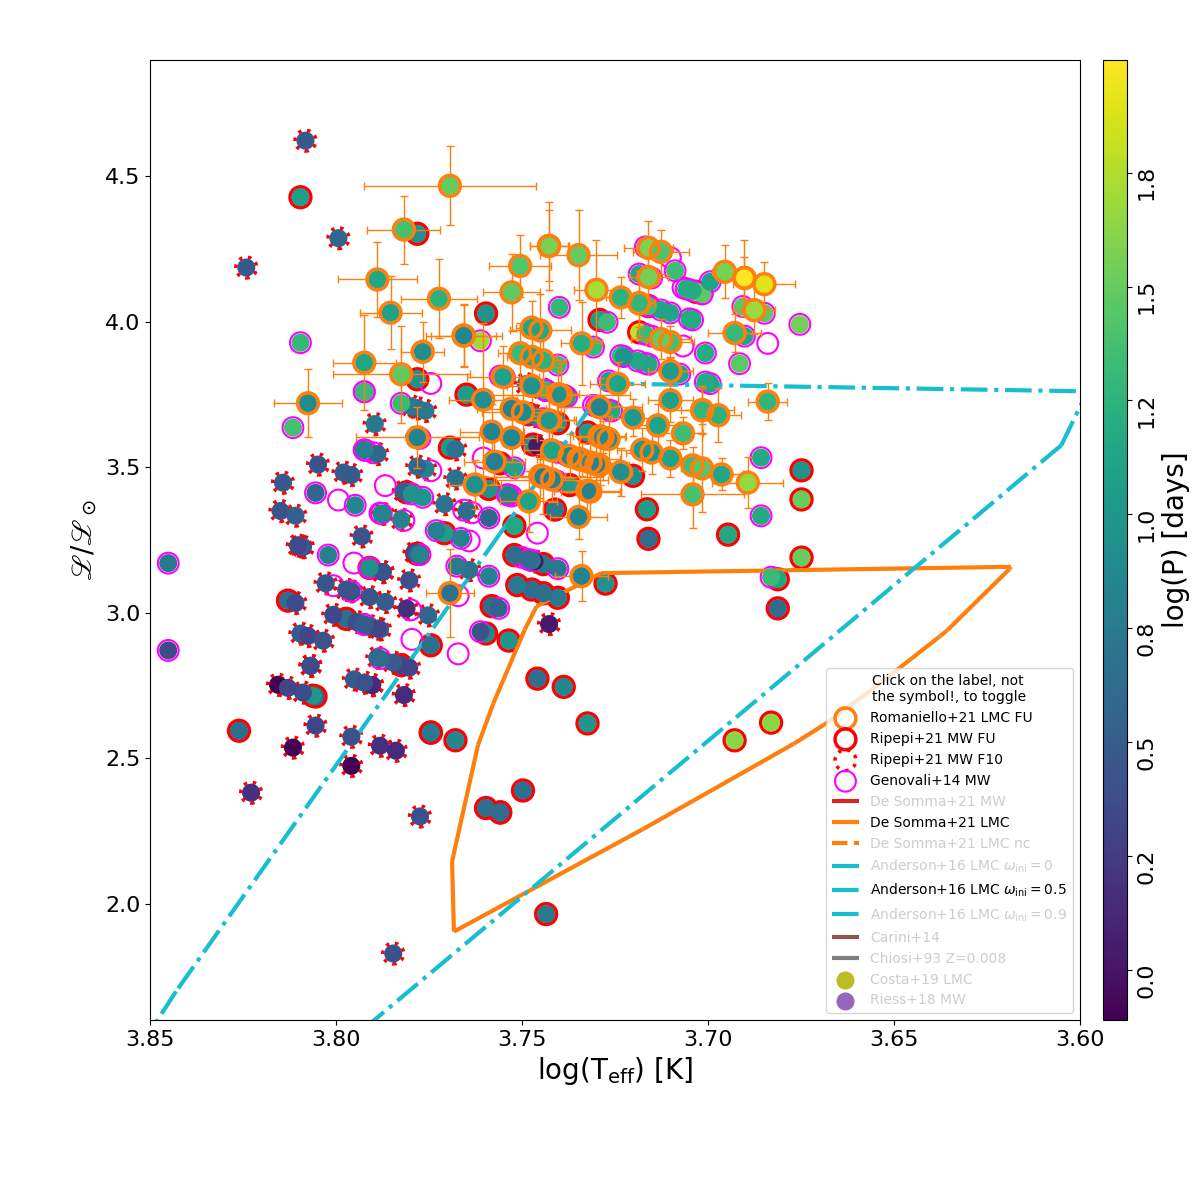

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
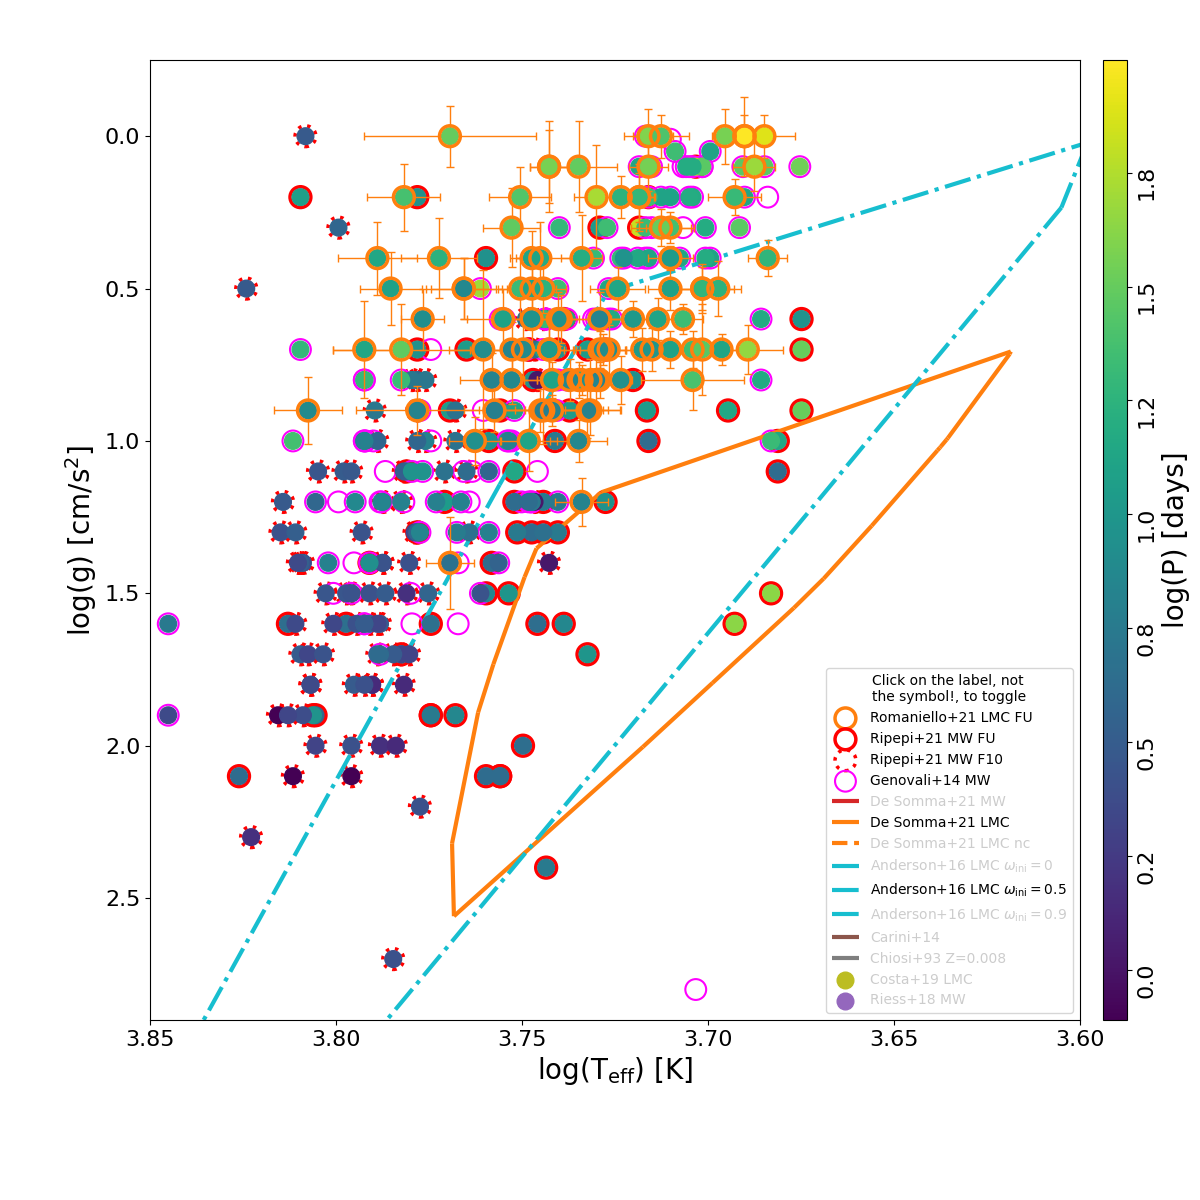

In [2]:
import matplotlib
import numpy as np
from astropy.io import ascii
from astropy import constants as const

#matplotlib.use('Qt5Agg')  # Force a backend that supports specifying the location of the plot window
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial import ConvexHull
from matplotlib.collections import LineCollection
from pylab import MaxNLocator
import sys, argparse
from types import SimpleNamespace



# ______________________________________________________________________________________________________________________
# _______________________________________________ Convenience functions ________________________________________________
def compute_logli(logg, logte, dlogg=None, dlogte=None):
    # Inverse of Rolf's flux-weighted gravity
    logli = 4 * logte - logg - 10.61
    if dlogg is not None and dlogte is not None:
        dlogli = np.sqrt((4 * dlogte)**2 + (dlogg)**2)
    else:
        dlogli = None
    return logli, dlogli

def compute_logg(logl, logte, mass):
    logr2 = (logl + np.log10(const.L_sun.cgs.value)) - (np.log10(4 * np.pi * const.sigma_sb.cgs.value)
                                                        + 4. * logte)
    return np.log10(const.G.cgs.value * mass * const.M_sun.cgs.value) - logr2

def read_desomma(infile):
    tab = ascii.read(infile, delimiter=';')
    masss = p1.tab2arr(tab, 'M/Mo')
    logls = p1.tab2arr(tab, 'log(L/Lo)')
    logtes = p1.tab2arr(tab, 'logTe')

    logggs = compute_logg(logls, logtes, masss)
    return logtes, logggs

def read_anderson(omega_ini=0):
    if omega_ini == 0:
        data_start, data_end = 2, 15
    elif omega_ini == 0.5:
        data_start, data_end = 16, 34
    elif omega_ini == 0.9:
        data_start, data_end = 35, 48
    tab = ascii.read('Files/Anderson_2016_AA_591_8_TabA2.txt', data_start=data_start, data_end=data_end)

    masss = np.append(p1.tab2arr(tab, 'M_in'), p1.tab2arr(tab, 'M_in'))
    logls = np.append(p1.tab2arr(tab, 'log(L_in)'), p1.tab2arr(tab, 'log(L_out)'))
    logtes = np.append(p1.tab2arr(tab, 'log(Teff_in)'), p1.tab2arr(tab, 'log(Teff_out)'))
    logggs = compute_logg(logls, logtes, masss)

    return logtes, logggs

def draw_hull(ax, logtes, loggs, dots=True, **kwargs):
    allPoints = np.column_stack((logtes, loggs))
    hull = ConvexHull(allPoints)
    #
    line_segments = [hull.points[simplex] for simplex in hull.simplices]
    collection = ax.add_collection(LineCollection(line_segments, **kwargs))
    if dots:
        if 'color' in kwargs:
            color = kwargs['color']
        else:
            color = None
        ax.plot(logtes, loggs, marker='o', linestyle='', color=color)
    return collection

def read():
    ids, tes, dtes, lgP, phases, te_label, window_title = p1.select(what, 'Teff')
    ___, logtes, dlogtes, ___, ___, logte_label, ___ = p1.select(what, 'logTeff')
    ___, loggs, dloggs, ___, ___, logg_label, ___ = p1.select(what, 'logg')
    loglis, dloglis = compute_logli(loggs, logtes, dlogg=dloggs, dlogte=dlogtes)

    # De Somma+21 Cepeid models
    logtes_mw, loggs_mw = read_desomma('Files/track_mw_F_1p5_can.csv')
    logtes_lmc, loggs_lmc = read_desomma('Files/track_lmc_F_1p5_can.csv')
    logtes_lmcn, loggs_lmcn = read_desomma('Files/track_lmc_F_1p5_noncan.csv')
    loglis_mw, ___ = compute_logli(loggs_mw, logtes_mw)
    loglis_lmc, ___ = compute_logli(loggs_lmc, logtes_lmc)
    loglis_lmcn, ___ = compute_logli(loggs_lmcn, logtes_lmcn)

    # Theoretical instability strip by Anderson+2016
    logtes_anderson0, loggs_anderson0 = read_anderson(omega_ini=0)
    loglis_anderson0, ___ = compute_logli(loggs_anderson0, logtes_anderson0)
    #
    logtes_anderson05, loggs_anderson05 = read_anderson(omega_ini=0.5)
    loglis_anderson05, ___ = compute_logli(loggs_anderson05, logtes_anderson05)
    #
    logtes_anderson09, loggs_anderson09 = read_anderson(omega_ini=0.9)
    loglis_anderson09, ___ = compute_logli(loggs_anderson09, logtes_anderson09)

    # Theoretical instability strip
    tab = ascii.read('Files/Carini_2014_AA_561_110_Tab1.txt')
    Z_car, Y_car = p1.tab2arr(tab, 'Z'), p1.tab2arr(tab, 'Y')
    masss_car, logls_car = p1.tab2arr(tab, 'M/Mo'), p1.tab2arr(tab, 'log_L/Lo')
    logtes_fbe_car, logtes_fre_car = np.log10(p1.tab2arr(tab, 'Te(FBE)')), np.log10(p1.tab2arr(tab, 'Te(FRE)'))
    loggs_fbe_car = compute_logg(logls_car, logtes_fbe_car, masss_car)
    loggs_fre_car = compute_logg(logls_car, logtes_fre_car, masss_car)
    loglis_fbe_car, ___ = compute_logli(loggs_fbe_car, logtes_fbe_car)
    loglis_fre_car, ___ = compute_logli(loggs_fre_car, logtes_fre_car)
    #
    logtes_car = np.append(logtes_fre_car, logtes_fbe_car)
    loggs_car = np.append(loggs_fre_car, loggs_fbe_car)
    loglis_car = np.append(loglis_fre_car, loglis_fbe_car)

    # Theoretical instability strip
    tab = ascii.read('Files/Chiosi_1993_ApJS_86_541_Tab8.txt')
    masss_chiosi, logls_chiosi = p1.tab2arr(tab, 'M/Mo'), p1.tab2arr(tab, 'log(L/Lo)')
    logtes_fbe_chiosi, logtes_fre_chiosi = p1.tab2arr(tab, 'log(Teff_blue)'), p1.tab2arr(tab, 'log(Teff_red)')
    #
    loggs_fbe_chiosi = compute_logg(logls_chiosi, logtes_fbe_chiosi, masss_chiosi)
    loggs_fre_chiosi = compute_logg(logls_chiosi, logtes_fre_chiosi, masss_chiosi)
    loglis_fbe_chiosi, ___ = compute_logli(loggs_fbe_chiosi, logtes_fbe_chiosi)
    loglis_fre_chiosi, ___ = compute_logli(loggs_fre_chiosi, logtes_fre_chiosi)
    #
    logtes_chiosi = np.append(logtes_fre_chiosi, logtes_fbe_chiosi)
    loggs_chiosi = np.append(loggs_fre_chiosi, loggs_fbe_chiosi)
    loglis_chiosi = np.append(loglis_fre_chiosi, loglis_fbe_chiosi)
    Y_car = np.append(Y_car, Y_car)

    # MW Cepheids
    tab = ascii.read('Files/Ripepi_2021_MNRAS_Tab2.txt', fast_reader=False)
    ids_rip = p1.tab2arr(tab, 'ID')
    for ii in np.arange(1, len(ids_rip)):
        if ids_rip[ii] == '---':
            ids_rip[ii] = ids_rip[ii-1]
    phases_rip = p1.tab2arr(tab, 'phase')
    loggs_rip = p1.tab2arr(tab, 'logg')
    logtes_rip = np.log10(p1.tab2arr(tab, 'Teff'))
    loglis_rip, ___ = compute_logli(loggs_rip, logtes_rip)
    #
    tab = ascii.read('Files/Ripepi_2021_MNRAS_Tab4.txt', fast_reader=False)
    stars_tmp = np.char.replace(p1.tab2arr(tab, 'Star'), '_', '')
    modes_tmp = p1.tab2arr(tab, 'Mode')
    lgP_tmp = np.log10(p1.tab2arr(tab, 'P'))
    #
    modes_rip = np.chararray(len(ids_rip), itemsize=10, unicode=True)
    lgP_rip = np.zeros(len(ids_rip))
    for star, mode, lP in zip(stars_tmp, modes_tmp, lgP_tmp):
        indices = [i for i, x in enumerate(ids_rip) if x == star]
        modes_rip[indices] = mode
        lgP_rip[indices] = lP

    # Stars from Riess et al (2018). These are not Cepheids, but field stars for GAIA use.
    tab = ascii.read('Files/Riess_2018_ApJ_855_136_Tab2.txt')
    loggs_riess = p1.tab2arr(tab, 'Logg')
    logtes_riess = np.log10(np.array(tab['T_eff']))
    loglis_riess, ___ = compute_logli(loggs_riess, logtes_riess)

    # Cepheids in LMC cluster NGC1866
    tab = ascii.read('Files/Costa_2019_AA_631_A128_Tab1.txt')
    masss_costa = p1.tab2arr(tab, 'Mass_[Mo]')
    logls_costa = p1.tab2arr(tab, 'logL_[Lo]')
    logtes_costa = np.log10(p1.tab2arr(tab, 'Teff_[K]'))
    loggs_costa = compute_logg(logls_costa, logtes_costa, masss_costa)
    loglis_costa, ___ = compute_logli(loggs_costa, logtes_costa)

    # MW Cepheids
    tab = ascii.read('Files/Genovali_2014_AA_566_A37_Tab1.txt')
    names_genovali = p1.tab2arr(tab, 'Name')
    loggs_genovali = p1.tab2arr(tab, 'logg')
    logtes_genovali = np.log10(p1.tab2arr(tab, 'Teff'))
    loglis_genovali, ___ = compute_logli(loggs_genovali,logtes_genovali)
    #
    tab = ascii.read('Files/Genovali_2014_AA_566_A37_Tab3.txt')
    names_tmp = p1.tab2arr(tab, 'Name')
    types_tmp = p1.tab2arr(tab, 'Type')
    lgP_tmp = p1.tab2arr(tab, 'log(P)')
    #
    types_genovali = np.chararray(len(names_genovali), itemsize=10, unicode=True)
    lgP_genovali = np.empty(len(names_genovali))
    lgP_genovali[:] = np.nan
    for star, mode, lP in zip(names_tmp, types_tmp, lgP_tmp):
        indices = [i for i, x in enumerate(names_genovali) if x.lower() == star.lower()]
        types_genovali[indices] = mode
        lgP_genovali[indices] = lP

    # Return all of the variables define in the function
    return locals()


# ______________________________________________________________________________________________________________________


def hrd():
    fig1, ax11 = plt.subplots(figsize=figsize)
    # p1.set_window_position(fig1, 0, 20)
    fig1.canvas.set_window_title('Figure 1: ' + n.window_title)
    # fig1.subplots_adjust(top=0.95, bottom=0.2)
    ax11.set_xlabel(p1.latex(n.logte_label, '\mathrm'))
    ax11.set_ylabel(p1.latex(n.logg_label, '\mathrm'))
    ax11.set_xlim(3.85, 3.6)
    ax11.set_ylim(2.9, -0.25)
    #
    fig2, ax21 = plt.subplots(figsize=figsize)
    # p1.set_window_position(fig2, 1200, 20)
    fig2.canvas.set_window_title('Figure 2: ' + n.window_title)
    # fig2.subplots_adjust(top=0.95, bottom=0.2)
    ax21.set_xlabel(p1.latex(n.logte_label, '\mathrm'))
    ax21.set_ylabel(r'$\mathscr{L} / \mathscr{L}_\odot$')
    ax21.set_xlim(3.85, 3.6)
    ax21.set_ylim(1.6, 4.9)

    mode0_rip, Y_car0 = 'DCEP_F', 0.25
    def plot(ax, yys):
        colormap = cm.viridis
        lgP_all = np.concatenate((n.lgP, n.lgP_rip, np.isfinite(n.lgP_genovali)))
        norm = matplotlib.colors.Normalize(vmin=np.min(lgP_all), vmax=np.max(lgP_all))

        lines, labels, label_texts, label_visibility = [], [], [], []

        rom_errs = ax.errorbar(n.logtes, yys['rom'], xerr=n.dlogtes, yerr=yys['drom'], fmt='.', markersize=1, capsize=3,
                         color='tab:orange', zorder=5, linewidth=1)
        rom_cmap = ax.scatter(n.logtes, yys['rom'], c=n.lgP, cmap=colormap, norm=norm, s=12**2, marker='o', zorder=7)
        rom_dots = ax.scatter(n.logtes, yys['rom'], s=15**2, facecolors='none', edgecolors='tab:orange',
                   zorder=7, linewidths=2.5)
        lines.append((rom_dots, rom_cmap, rom_errs))
        label_texts.append('Romaniello+21 LMC FU')
        label_visibility.append(True)
        labels.append(rom_dots)
        #
        se = n.modes_rip == mode0_rip
        rip0_cmap = ax.scatter(n.logtes_rip[(se)], yys['rip'][(se)], marker='o', c=n.lgP_rip[(se)],
                               cmap=colormap, norm=norm, s=12**2, zorder=3)
        rip0_dots = ax.scatter(n.logtes_rip[(se)], yys['rip'][(se)], s=15**2, linewidths=2.5, linestyle='-',
                               facecolors='none', edgecolors='red')
        lines.append((rip0_cmap, rip0_dots))
        label_texts.append('Ripepi+21 MW FU')
        label_visibility.append(True)
        labels.append(rip0_dots)
        #
        se = n.modes_rip != mode0_rip
        rip10_cmap = ax.scatter(n.logtes_rip[(se)], yys['rip'][(se)], marker='o', c=n.lgP_rip[se], cmap=colormap,
                                norm=norm, s=12 ** 2, zorder=3)
        rip10_dots = ax.scatter(n.logtes_rip[(se)], yys['rip'][(se)], s=15**2, linewidths=2.5, linestyle=':',
                                facecolors='none', edgecolors='red')
        lines.append((rip10_cmap, rip10_dots))
        label_texts.append('Ripepi+21 MW F10')
        label_visibility.append(True)
        labels.append(rip10_dots)
        #
        genovali_cmap = ax.scatter(n.logtes_genovali, yys['genovali'], marker='o', c=n.lgP_genovali, cmap=colormap,
                                   norm=norm, s=12**2, zorder=3)
        genovali_dots = ax.scatter(n.logtes_genovali, yys['genovali'], s=15**2, linewidths=1.5, linestyle='-',
                                   facecolors='none', edgecolors='magenta')
        lines.append((genovali_cmap, genovali_dots))
        label_texts.append('Genovali+14 MW')
        label_visibility.append(True)
        labels.append(genovali_dots)
        #
        desommaMW_hull = draw_hull(ax, n.logtes_mw, yys['dsm_mw'], dots=False, color='C3', linewidth=3)
        lines.append(desommaMW_hull)
        label_texts.append('De Somma+21 MW')
        label_visibility.append(False)
        labels.append(desommaMW_hull)
        #
        desommaLMC_hull = draw_hull(ax, n.logtes_lmc, yys['dsm_lmc'], dots=False, color='C1', linewidth=3)
        lines.append(desommaLMC_hull)
        label_texts.append('De Somma+21 LMC')
        label_visibility.append(True)
        labels.append(desommaLMC_hull)
        #
        desommaLMCnc_hull = draw_hull(ax, n.logtes_lmcn, yys['dsm_lmcn'], dots=False, color='C1', linestyle='--',
                                    linewidth=3)
        lines.append(desommaLMCnc_hull)
        label_texts.append('De Somma+21 LMC nc')
        label_visibility.append(False)
        labels.append(desommaLMCnc_hull)
        #
        anderson0_hull = draw_hull(ax, n.logtes_anderson0, yys['anderson0'], dots=False, color='C9', linewidth=3,
                                    linestyle='-')
        lines.append(anderson0_hull)
        label_texts.append(r'Anderson+16 LMC $\omega_\mathrm{ini}=0$')
        label_visibility.append(False)
        labels.append(anderson0_hull)
        #
        anderson05_hull = draw_hull(ax, n.logtes_anderson05, yys['anderson05'], dots=False, color='C9', linewidth=3,
                                     linestyle='-.')
        lines.append(anderson05_hull)
        label_texts.append(r'Anderson+16 LMC $\omega_\mathrm{ini}=0.5$')
        label_visibility.append(True)
        labels.append(anderson05_hull)
        #
        anderson09_hull = draw_hull(ax, n.logtes_anderson09, yys['anderson09'], dots=False, color='C9', linewidth=3,
                                     linestyle='-.')
        lines.append(anderson09_hull)
        label_texts.append(r'Anderson+16 LMC $\omega_\mathrm{ini}=0.9$')
        label_visibility.append(False)
        labels.append(anderson09_hull)
        #
        car_hull = draw_hull(ax, n.logtes_car[(n.Y_car == Y_car0)], yys['car'][(n.Y_car == Y_car0)], dots=False,
                              color='C5', linewidth=3)
        lines.append(car_hull)
        label_texts.append('Carini+14')
        label_visibility.append(False)
        labels.append(car_hull)
        #
        chiosi_hull = draw_hull(ax, n.logtes_chiosi, yys['chiosi'], dots=False, linewidth=3, color='C7')
        lines.append(chiosi_hull)
        label_texts.append('Chiosi+93 Z=0.008')
        label_visibility.append(False)
        labels.append(chiosi_hull)
        #
        costa_dots = ax.scatter(n.logtes_costa, yys['costa'], color='C8', s=12**2, zorder=1)
        lines.append(costa_dots)
        label_texts.append('Costa+19 LMC')
        label_visibility.append(False)
        labels.append(costa_dots)
        #
        riess_dots = ax.scatter(n.logtes_riess, yys['riess'], color='C4', s=12**2, zorder=1)
        lines.append(riess_dots)
        label_texts.append('Riess+18 MW')
        label_visibility.append(False)
        labels.append(riess_dots)

        # Add the legend ...
        leg = ax.legend(labels, label_texts, fontsize=10, loc='lower right',
                        title='Click on the label, not\nthe symbol!, to toggle', title_fontsize=10)
        # ... and the colorbar
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        cax = ax.inset_axes([1.025, 0., 0.025, 1], transform=ax.transAxes)
        cb = plt.gcf().colorbar(sm, ticks=None, ax=ax, cax=cax)
        cb.ax.set_yticklabels(['{:.1f}'.format(x) for x in cb.ax.get_yticks()], rotation=90)
        cb.ax.set_ylabel('log(P) [days]')

        lined = {}
        for legtext, legvisi, origline in zip(leg.get_texts(), label_visibility, lines):
            legtext.set_picker(True)  # Enable picking on the legend label/text
            legtext.set_alpha(1 if legvisi else 0.2)  # Set the initial transparency
            lined[legtext] = origline  # Make the correspondence between legend entry and line/dots
            # Set the initial visibility ...
            if type(origline) is not tuple:
                origline = (origline, )
            for ol in origline:
                if type(ol) is not matplotlib.container.ErrorbarContainer:
                    ol.set_visible(legvisi)
                else:
                    ol[0].set_visible(legvisi)
                    for ole in (1, len(ol)-1):
                        for oli in ol[ole]:
                            oli.set_visible(legvisi)

        def on_pick(event):
            # On the pick event, find the original line corresponding to the legend
            # proxy line, and toggle its visibility.
            legtext = event.artist
            origline = lined[legtext]
            if type(origline) is not tuple:
                origline = (origline, )
            for ol in origline:
                if type(ol) is not matplotlib.container.ErrorbarContainer:
                    visible = not ol.get_visible()
                    ol.set_visible(visible)
                else:
                    visible = not ol[0].get_visible()
                    ol[0].set_visible(visible)
                    for ole in (1, len(ol)-1):
                        for oli in ol[ole]:
                            visible = not oli.get_visible()
                            oli.set_visible(visible)
            # Change the alpha on the line in the legend so we can see what lines
            # have been toggled.
            legtext.set_alpha(1.0 if visible else 0.2)
            # legtext._legmarker.set_alpha(1.0 if visible else 0.2)
            ax.get_figure().canvas.draw()
        ax.get_figure().canvas.mpl_connect('pick_event', on_pick)

    gg = {'rom': n.loggs, 'drom': n.dloggs, 'dsm_mw': n.loggs_mw, 'dsm_lmc': n.loggs_lmc, 'dsm_lmcn': n.loggs_lmcn,
          'rip': n.loggs_rip, 'riess': n.loggs_riess, 'car': n.loggs_car, 'chiosi': n.loggs_chiosi,
          'costa': n.loggs_costa, 'genovali': n.loggs_genovali, 'anderson0': n.loggs_anderson0,
          'anderson05': n.loggs_anderson05, 'anderson09': n.loggs_anderson09}
    plot(ax11, gg)
    #
    ll = {'rom': n.loglis, 'drom': n.dloglis, 'dsm_mw': n.loglis_mw, 'dsm_lmc': n.loglis_lmc, 'dsm_lmcn': n.loglis_lmcn,
          'rip': n.loglis_rip, 'riess': n.loglis_riess, 'car': n.loglis_car, 'chiosi': n.loglis_chiosi,
          'costa': n.loglis_costa, 'genovali': n.loglis_genovali, 'anderson0': n.loglis_anderson0,
          'anderson05': n.loglis_anderson05, 'anderson09': n.loglis_anderson09}
    plot(ax21, ll)

    
def figs():
    mode0_rip, Y_car0 = 'DCEP_F', 0.25

    fig1, ax11 = plt.subplots(figsize=figsize)
#     p1.set_window_position(fig1, 0, 20)
    fig1.canvas.set_window_title('Figure 1: ' + n.window_title)
    # fig1.subplots_adjust(top=0.95, bottom=0.2)
    ax11.set_xlabel(p1.latex(n.logg_label, '\mathrm'))
    ax11.set_ylabel('Number')
    ___, bins, ___ = ax11.hist(n.loggs, bins=5, zorder=1, color='royalblue', histtype=u'step', linewidth=3,
                               label='Romaniello+21')
    ax11.hist(n.loggs_rip[(n.modes_rip == mode0_rip)], bins=bins, zorder=1, color='orangered', histtype=u'step',
              linewidth=3, label='Ripepi+21 FU')
    ax11.hist(n.loggs_rip, bins=bins, zorder=1, color='orangered', histtype=u'step', linewidth=2, linestyle='--',
              label='Ripepi+21 all')
    ax11.legend()

    fig2, ax21 = plt.subplots(figsize=figsize)
#     p1.set_window_position(fig2, 1500, 20)
    fig2.canvas.set_window_title('Figure 2: ' + n.window_title)
    # fig2.subplots_adjust(top=0.95, bottom=0.2)
    ax21.set_xlabel('log(P) [days]')
    ax21.set_ylabel(p1.latex(n.logg_label, '\mathrm'))
    #
    # ax21.plot(n.lgP, n.loggs, marker='o', linestyle='', color='tab:orange', markersize=12, zorder=5,
              # label='Romaniello+21 LMC')
    ax21.errorbar(n.lgP, n.loggs, yerr=n.dloggs, fmt='o', capsize=5, markersize=12, label='Romaniello+21 LMC')
    ax21.plot(n.lgP_rip[(n.modes_rip == mode0_rip)], n.loggs_rip[(n.modes_rip == mode0_rip)], marker='o', linestyle='',
              color='red', markersize=12, zorder=3, label='Ripepi+21 MW FU')
    ax21.plot(n.lgP_genovali, n.loggs_genovali, marker='o', linestyle='', color='magenta', markersize=12, zorder=5,
              label='Genovali+14 LMC')
    ax21.legend()

    fig3, ax31 = plt.subplots(figsize=figsize)
#     p1.set_window_position(fig3, 750, 20)
    fig3.canvas.set_window_title('Figure 3: ' + n.window_title)
    # fig3.subplots_adjust(top=0.95, bottom=0.2)
    ax31.set_xlabel('Phases')
    ax31.set_ylabel(p1.latex(n.logg_label, '\mathrm'))
    #
    # ax31.plot(n.phases, n.loggs, marker='o', linestyle='', color='tab:orange', markersize=12, zorder=5,
              # label='Romaniello+21 LMC')
    ax31.errorbar(n.phases, n.loggs, yerr=n.dloggs, fmt='o', capsize=5, markersize=12, label='Romaniello+21 LMC')
    ax31.plot(n.phases_rip[(n.modes_rip == mode0_rip)], n.loggs_rip[(n.modes_rip == mode0_rip)], marker='o', linestyle='',
              color='red', markersize=12, zorder=3, label='Ripepi+21 MW FU')
    ax31.legend()

    fig4, ax41 = plt.subplots(figsize=figsize)
#     p1.set_window_position(fig4, 2250, 20)
    fig4.canvas.set_window_title('Figure 4: ' + n.window_title)
    # fig4.subplots_adjust(top=0.95, bottom=0.2)
    ax41.set_xlabel('Phases')
    ax41.set_ylabel(p1.latex(n.logte_label, '\mathrm'))
    #
    # ax41.plot(n.phases, n.logtes, marker='o', linestyle='', color='tab:orange', markersize=12, zorder=5,
              # label='Romaniello+21 LMC')
    ax41.errorbar(n.phases, n.tes, yerr=n.dtes, fmt='o', capsize=5, markersize=12, label='Romaniello+21 LMC')
    ax41.plot(n.phases_rip[(n.modes_rip == mode0_rip)], 10**(n.logtes_rip[(n.modes_rip == mode0_rip)]),
              marker='o', linestyle='', color='red', markersize=12, zorder=3, label='Ripepi+21 MW FU')
    ax41.legend()
    
    fig5, ax51 = plt.subplots(figsize=(12, 12))
#     p1.set_window_position(fig5, 2250, 20)
    fig5.canvas.set_window_title('Figure 5: ' + n.window_title)
    # fig5.subplots_adjust(top=0.95, bottom=0.2)
    ax51.set_xlabel('log(P) [days]')
    ax51.set_ylabel(r'$\log(\mathrm{g}_\mathrm{F})$')
    #
    # ax51.plot(n.loggs, 1 / n.loglis, marker='o', linestyle='', color='tab:orange', markersize=12, zorder=5,
              # label='Romaniello+21 LMC')
    ax51.errorbar(n.loggs, 1/n.loglis, yerr=n.dloglis / n.loglis**2, fmt='o', capsize=5, markersize=12, label='Romaniello+21 LMC')
    ax51.plot(n.loggs_rip[(n.modes_rip == mode0_rip)], 1 / n.loglis_rip[(n.modes_rip == mode0_rip)],
              marker='o', linestyle='', color='red', markersize=12, zorder=3, label='Ripepi+21 MW FU')
    ax51.legend()

# ______________________________________________________________________________________________________________________
import paper1_figures as p1

# parser = argparse.ArgumentParser()
# parser.add_argument('what_plot', help='What plot to plot', type=str)
# args = parser.parse_args()

plt.style.use('Files/paper.mplstyle')

try:
    figsize
except NameError:
    figsize = (12, 12)

# Read the inputs from file
p1.ids_mag, p1.logPs, p1.mags, p1.emags, geo, pl_slope, pl_intercept, pl_scatter = p1.read_riess()
p1.stellar_parameters_r08, p1.intrinsic_parameters_r08 = p1.read_r08('LMC')  # R08 from the paper
#
p1.stellar_parametersTotal_alllines, __, __ = \
    p1.read_parameters('SH0ES_atmparam_FREETotal_alllines_all.dat')  # Martino exc balance from 5500 K ... preferred
p1.stellar_parametersT08M, __, __ = p1.read_parameters(
    'LMC_R08_atmparam_FREETotal_alllines_all.dat')  # R08 Martino exc balance ... preferred

# what = 'RT20M'  # R08 analysed by Martino w/ exc balance Teff, all Genovali lines  ... Preferred
# what = 'Tot20all'  # SH0ES sample analysed by Martino w/ exc balance Teff, full Genovali linelist ### Preferred
what = 'Tot20allRT20M'  # SH0ES2020 + R08 samples analysed by Martino w/ exc balance Teff, full Genovali linelist

tmp = read()
n = SimpleNamespace(**tmp)

if what_plot == 'hrd':
    hrd()
    plt.show()
elif what_plot == 'figs':
    figs()
    plt.show()